In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import glob
import itertools
import pandas as pd
#import splitfolders
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix

In [2]:
train_data_dir = r"D:/experiments/Datasets/ip102_v1.1-002/ip102_v1.1/prepared_data/train/"
valid_data_dir = r"D:/experiments/Datasets/ip102_v1.1-002/ip102_v1.1/prepared_data/val/"
test_data_dir = r"D:/experiments/Datasets/ip102_v1.1-002/ip102_v1.1/prepared_data/test/"

In [3]:
classes = ['rice leaf roller',
        'rice leaf caterpillar',
        'paddy stem maggot',
        'asiatic rice borer',
        'yellow rice borer',
        'rice gall midge',
        'Rice Stemfly',
        'brown plant hopper',
        'white backed plant hopper',
        'small brown plant hopper',
        'rice water weevil',
        'rice leafhopper',
        'grain spreader thrips',
        'rice shell pest',
        'grub',
        'mole cricket',
        'wireworm',
        'white margined moth',
        'black cutworm',
        'large cutworm',
        'yellow cutworm',
        'red spider',
        'corn borer',
        'army worm',
        'aphids',
        'Potosiabre vitarsis',
        'peach borer',
        'english grain aphid',
        'green bug',
        'bird cherry-oataphid',
        'wheat blossom midge',
        'penthaleus major',
        'longlegged spider mite',
        'wheat phloeothrips',
        'wheat sawfly',
        'cerodonta denticornis',
        'beet fly',
        'flea beetle',
        'cabbage army worm',
        'beet army worm',
        'Beet spot flies',
        'meadow moth',
        'beet weevil',
        'sericaorient alismots chulsky',
        'alfalfa weevil',
        'flax budworm',
        'alfalfa plant bug',
        'tarnished plant bug',
        'Locustoidea',
        'lytta polita',
        'legume blister beetle',
        'blister beetle',
        'therioaphis maculata Buckton',
        'odontothrips loti',
        'Thrips',
        'alfalfa seed chalcid',
        'Pieris canidia',
        'Apolygus lucorum',
        'Limacodidae',
        'Viteus vitifoliae',
        'Colomerus vitis',
        'Brevipoalpus lewisi McGregor',
        'oides decempunctata',
        'Polyphagotars onemus latus',
        'Pseudococcus comstocki Kuwana',
        'parathrene regalis',
        'Ampelophaga',
        'Lycorma delicatula',
        'Xylotrechus',
        'Cicadella viridis',
        'Miridae',
        'Trialeurodes vaporariorum',
        'Erythroneura apicalis',
        'Papilio xuthus',
        'Panonchus citri McGregor',
        'Phyllocoptes oleiverus ashmead',
        'Icerya purchasi Maskell',
        'Unaspis yanonensis',
        'Ceroplastes rubens',
        'Chrysomphalus aonidum',
        'Parlatoria zizyphus Lucus',
        'Nipaecoccus vastalor',
        'Aleurocanthus spiniferus',
        'Tetradacus c Bactrocera minax',
        'Dacus dorsalis(Hendel)',
        'Bactrocera tsuneonis',
        'Prodenia litura',
        'Adristyrannus',
        'Phyllocnistis citrella Stainton',
        'Toxoptera citricidus',
        'Toxoptera aurantii',
        'Aphis citricola Vander Goot',
        'Scirtothrips dorsalis Hood',
        'Dasineura sp',
        'Lawana imitata Melichar',
        'Salurnis marginella Guerr',
        'Deporaus marginatus Pascoe',
        'Chlumetia transversa',
        'Mango flat beak leafhopper',
        'Rhytidodera bowrinii white',
        'Sternochetus frigidus',
        'Cicadellidae'
]

# ResNet50

In [4]:
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
# datagen = ImageDataGenerator()

In [6]:
train_batchs_Res = datagen.flow_from_directory(directory=train_data_dir, target_size=(224,224), classes=classes, batch_size=64)

valid_batchs_Res = datagen.flow_from_directory(directory=valid_data_dir, target_size=(224,224), classes=classes, batch_size=64)

test_batchs_Res = datagen.flow_from_directory(directory=test_data_dir, target_size=(224,224), classes=classes, batch_size=64, shuffle=False)

Found 45095 images belonging to 102 classes.
Found 7508 images belonging to 102 classes.
Found 22619 images belonging to 102 classes.


In [7]:
base_model_Res = ResNet50(include_top = False, weights = 'imagenet')

In [8]:
x = base_model_Res.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(train_batchs_Res.num_classes, activation='softmax')(x)

modelRes = Model(inputs=base_model_Res.input, outputs=predictions)

for layer in base_model_Res.layers:
    layer.trainable = True

In [9]:
modelRes.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [10]:
callbacks = [
        ModelCheckpoint("SavedModels/resnet_50_model/model_resnet50_aug_unfiltered.h5", verbose=1, save_best_model=True),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=5, verbose=1)
    ]

In [11]:
history_Res = modelRes.fit(x = train_batchs_Res, 
            steps_per_epoch=train_batchs_Res.samples // 64,
            validation_data = valid_batchs_Res,
            validation_steps=valid_batchs_Res.samples // 64,
            epochs = 500, verbose = 1,
            callbacks=callbacks,)

Epoch 1/500
704/704 [==============================] - ETA: 0s - loss: 2.0707 - accuracy: 0.4934
Epoch 1: saving model to SavedModels/resnet_50_model\model_resnet50_aug_unfiltered.h5
704/704 [==============================] - 431s 607ms/step - loss: 2.0707 - accuracy: 0.4934 - val_loss: 3.4749 - val_accuracy: 0.2105 - lr: 1.0000e-04
Epoch 2/500
704/704 [==============================] - ETA: 0s - loss: 1.2861 - accuracy: 0.6474
Epoch 2: saving model to SavedModels/resnet_50_model\model_resnet50_aug_unfiltered.h5
704/704 [==============================] - 241s 342ms/step - loss: 1.2861 - accuracy: 0.6474 - val_loss: 1.5117 - val_accuracy: 0.5990 - lr: 1.0000e-04
Epoch 3/500
704/704 [==============================] - ETA: 0s - loss: 1.0193 - accuracy: 0.7089
Epoch 3: saving model to SavedModels/resnet_50_model\model_resnet50_aug_unfiltered.h5
704/704 [==============================] - 243s 345ms/step - loss: 1.0193 - accuracy: 0.7089 - val_loss: 1.4521 - val_accuracy: 0.6163 - lr: 1.0000

In [12]:
Res_model = tf.keras.models.load_model('SavedModels/resnet_50_model/model_resnet50_aug_unfiltered.h5')

Res_predictions = Res_model.predict(x=test_batchs_Res, verbose=0)

In [13]:
y_pred_Res = np.argmax(Res_predictions, axis=1)
y_true_Res = test_batchs_Res.classes

precision = precision_score(y_true_Res, y_pred_Res, average='weighted', zero_division=0)
print('Precision: %f' % precision)

recall = recall_score(y_true_Res, y_pred_Res, average='weighted', zero_division=0)
print('Recall: %f' % recall)

f1 = f1_score(y_true_Res, y_pred_Res, average='weighted', zero_division=0)
print('F1 score: %f' % f1)

accuracy = accuracy_score(y_true_Res, y_pred_Res)
print('Accuracy: %f' % accuracy)

Precision: 0.706627
Recall: 0.708785
F1 score: 0.706588
Accuracy: 0.708785


In [14]:
print(classification_report(y_true_Res, y_pred_Res, target_names = classes, zero_division=0))

                                 precision    recall  f1-score   support

               rice leaf roller       0.67      0.77      0.72       335
          rice leaf caterpillar       0.44      0.45      0.44       147
              paddy stem maggot       0.55      0.39      0.46        79
             asiatic rice borer       0.57      0.64      0.60       316
              yellow rice borer       0.63      0.58      0.60       152
                rice gall midge       0.75      0.70      0.73       152
                   Rice Stemfly       0.62      0.65      0.63       111
             brown plant hopper       0.54      0.48      0.51       251
      white backed plant hopper       0.48      0.54      0.51       268
       small brown plant hopper       0.51      0.51      0.51       166
              rice water weevil       0.78      0.77      0.78       257
                rice leafhopper       0.50      0.44      0.47       122
          grain spreader thrips       0.60      0.

In [15]:
#Get the filename including last folder
image_names = [os.path.basename(filename) for filename in test_batchs_Res.filenames]


# Get the image names from the ImageDataGenerator
image_names = test_batchs_Res.filenames

df = pd.DataFrame({'Image Name': image_names, 'Predicted': y_pred_Res, 'Ground Truth': y_true_Res})
df.to_csv('results_R50_cls_aug_unfiltered.csv', index=False)

(<Figure size 3600x3600 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

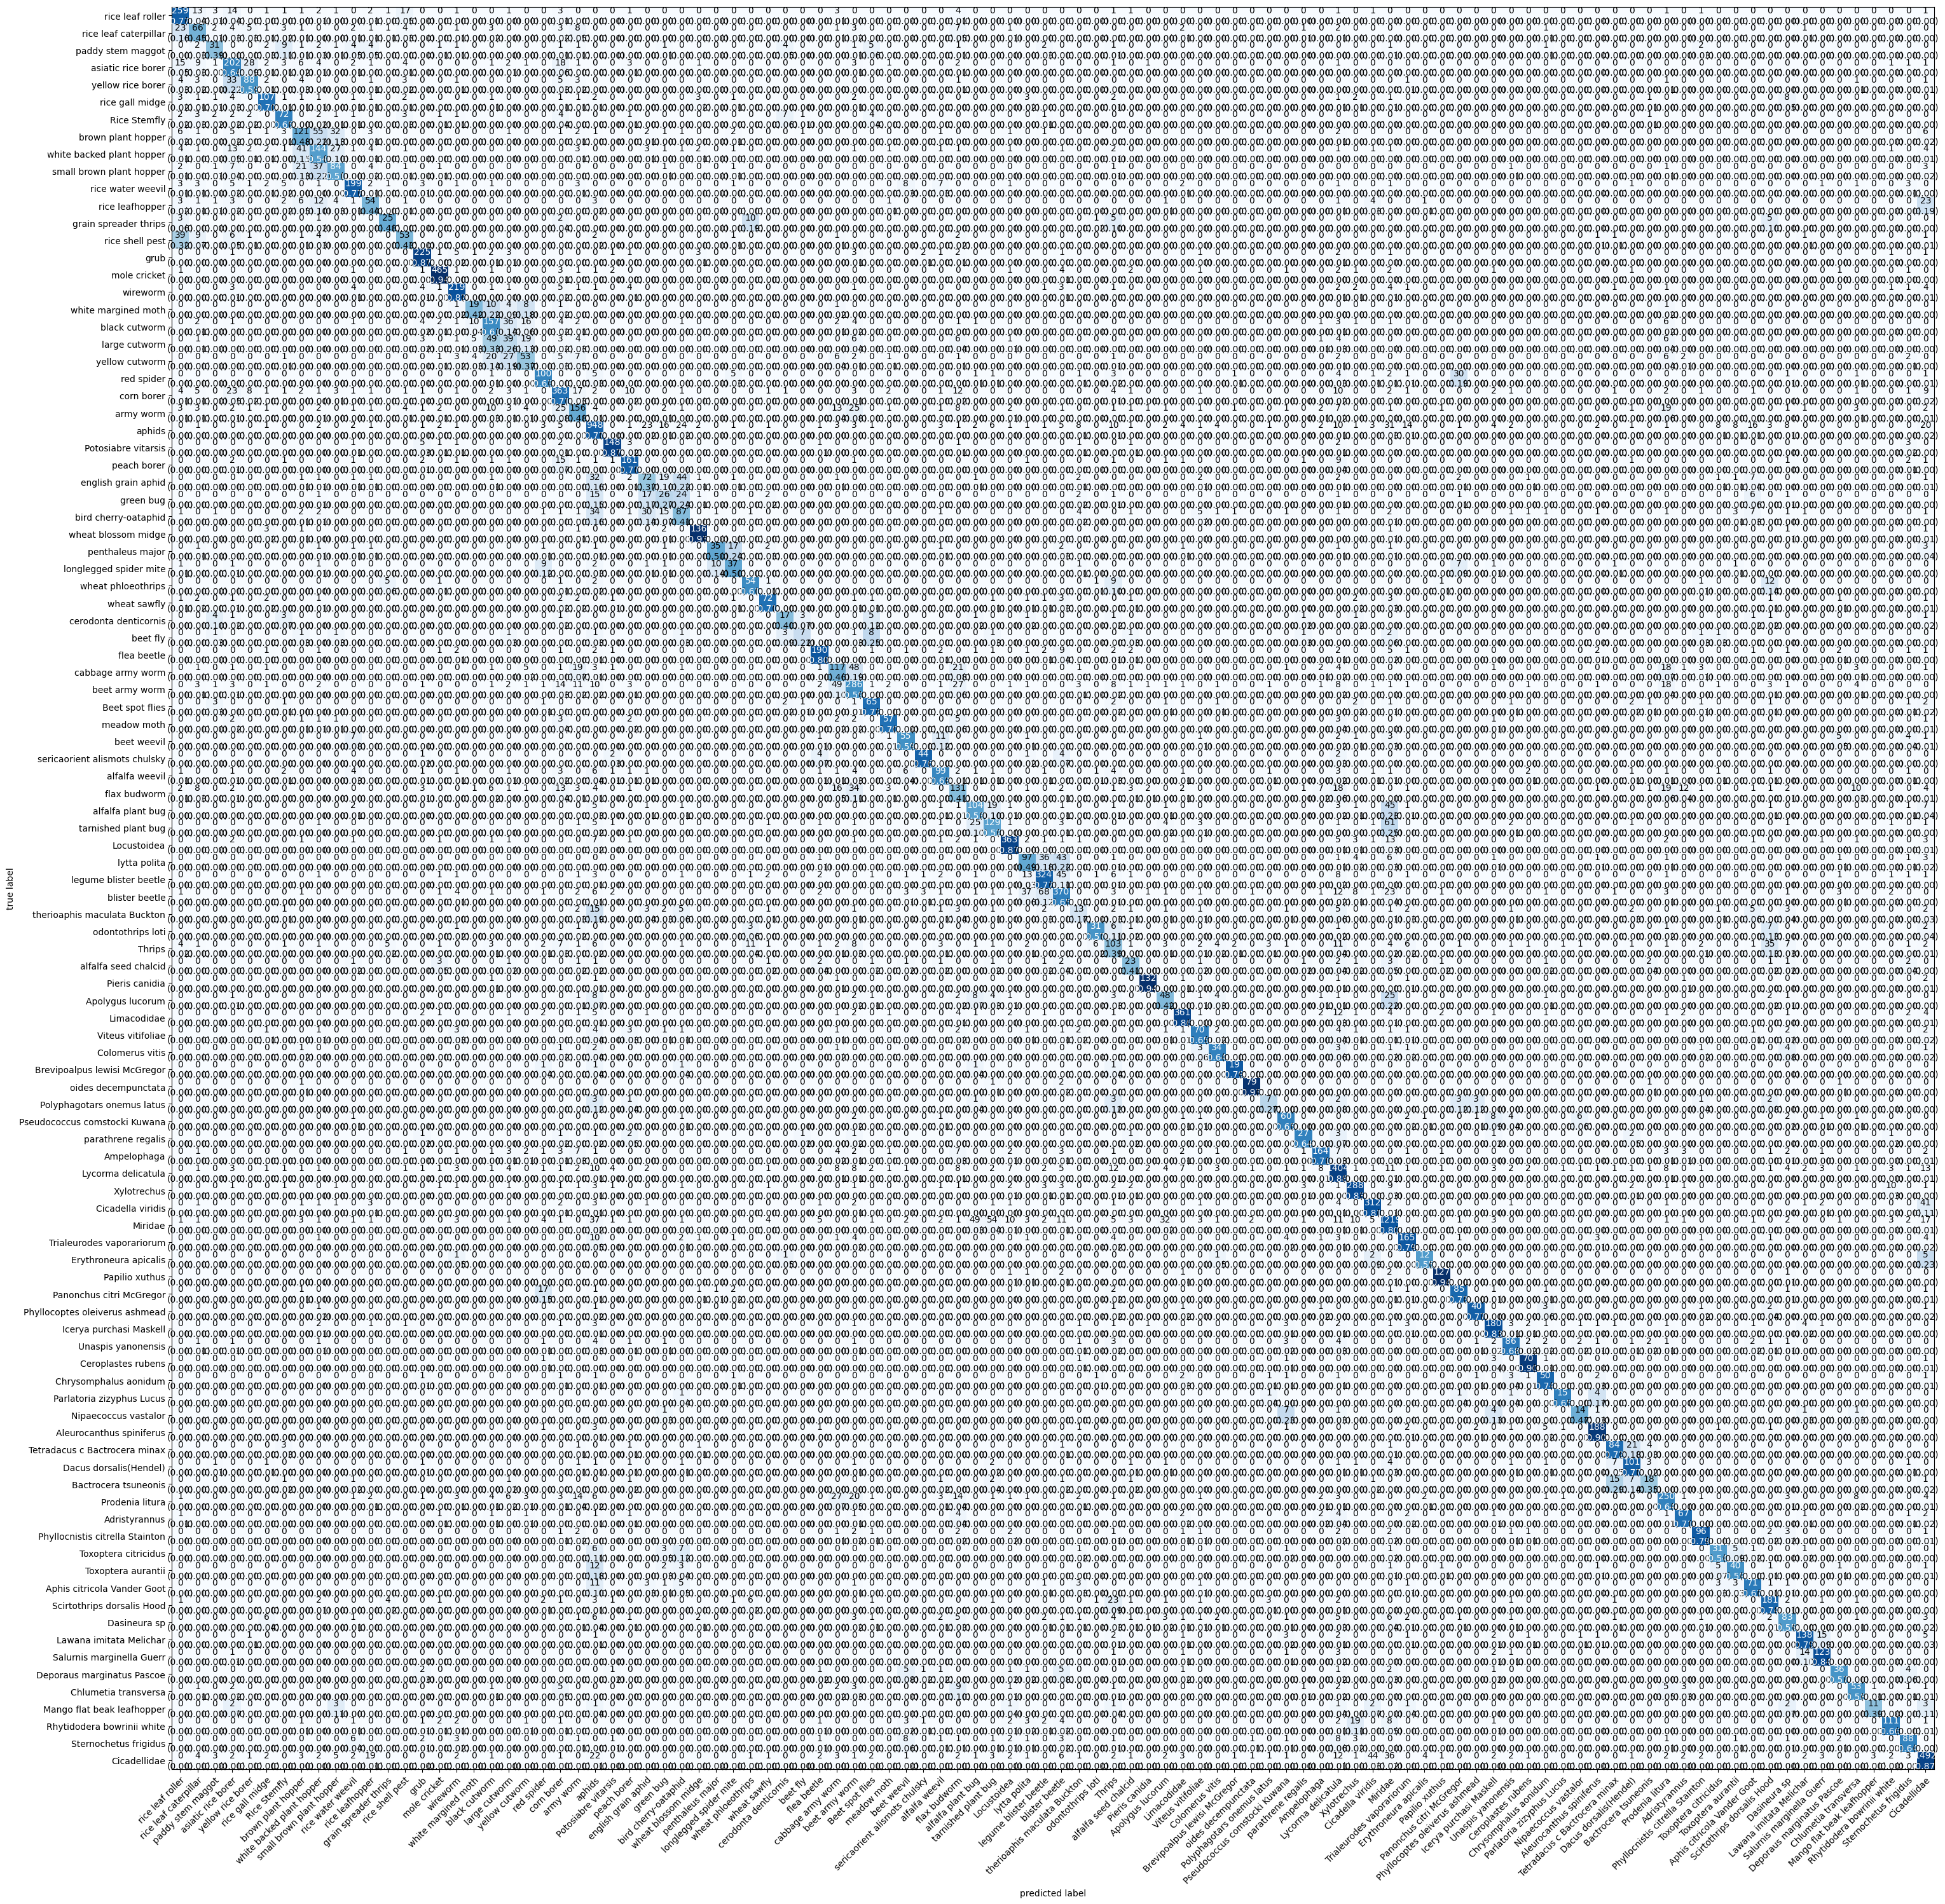

In [16]:
matRes = confusion_matrix(y_true_Res,y_pred_Res)
plot_confusion_matrix(matRes, figsize=(36,36), class_names=classes, show_normed=True)